# QA Image - Llava 0.5b

## Quantize and load model

In [1]:
import os
import torch
import re
import json

from dotenv import load_dotenv
from transformers import (
    BitsAndBytesConfig,
    LlavaProcessor,
    LlavaForConditionalGeneration,
)
from utils import extract_frames, show_frame, convert_frame_to_bytes

# Load environment
load_dotenv()

# Quantize model for lower storage
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load model
model_id = "llava-hf/llava-interleave-qwen-0.5b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    dtype=torch.float16,
    quantization_config=quantization_config,
)

# Load Prompt processor
processor = LlavaProcessor.from_pretrained(model_id)

/home/rapha/.cache/pypoetry/virtualenvs/clear-vision-backend-pHRXtyny-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Extract frames and their timestamps

In [2]:
video_path = os.path.abspath('../public/video_rua01.mp4')
frames, ts = extract_frames(video_path)
ts

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]

## Build Prompt

In [3]:
def _format_template_prompt(context):
    return (
        f"<|im_start|>user\n"
        f"<image>\n"
        f"{context}\n"
        f"<|im_end|>\n"
        f"<|im_start|>assistant\n"
    )


def format_prompt_qa_event_existence(question: str):
    context = (
        "Return ONLY JSON in the following format:\n"
        '{"exists": boolean, "description": string}\n'
        '- "exists" MUST strictly reflect if the target object is visible.\n'
        '- "description" MUST describe ALL visible objects in the frame.\n'
        "- Do NOT assume, guess, or infer anything not visible.\n"
        '- If the target is not present, "exists" must be false.\n'
        f'Target object: "{question}"\n'
        f"First, analyze the image neutrally.\n"
        f"Then answer strictly based on visible evidence.\n"
    )

    return _format_template_prompt(context=context)


def format_prompt_qa_frame_description():
    context = (
        "Return ONLY JSON in the following format:\n"
        '{"description": string}\n'
        '- "description" MUST describe ALL visible objects in the frame.\n'
        "- Do NOT assume, guess, or infer anything not visible.\n"
        f"Analyze the image neutrally.\n"
    )

    return _format_template_prompt(context=context)

## Process one frame

In [4]:
def format_response(response: str) -> dict:
    matches = re.search(r"(?<=assistant\n)\{[\s\S]*\}", response)

    if not matches:
        return {'exists': False, 'description': None}

    raw = matches.group(0)
    raw_dict = json.loads(raw)

    return raw_dict


def process_frame(frame, prompt):
    inputs = processor(
        text=prompt, images=frame, return_tensors="pt"
    ).to(model.device, model.dtype)

    output = model.generate(**inputs, max_new_tokens=200, do_sample=False)

    # MODEL DESCRIBES WELL THE IMAGE, HOWEVER IT IS STILL BIASED BY THE USER PROMPT (WONT DETECT EVERYTHING I EXPECTED ON THE IMAGE)
    response = processor.decode(output[0], skip_special_tokens=True)

    return format_response(response)

In [5]:
frame = frames[10]

process_frame(frame, format_prompt_qa_event_existence('black car crossing the street'))

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'Black car crossing the street'}

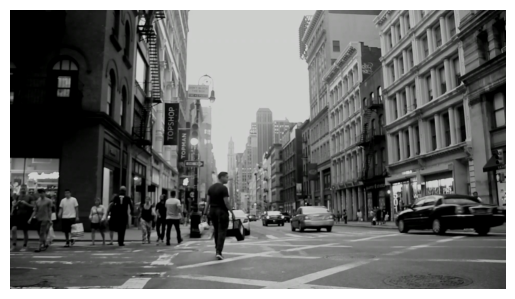

In [6]:
show_frame(frame)

In [7]:
convert_frame_to_bytes(frame)[:10]

b'\xff\xd8\xff\xe0\x00\x10JFIF'

## Process multiple frames

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing a street in a city setting.'}


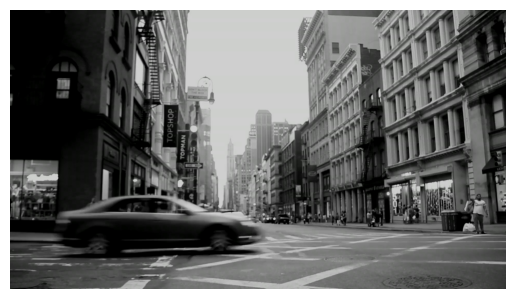

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing the street in a city setting.'}


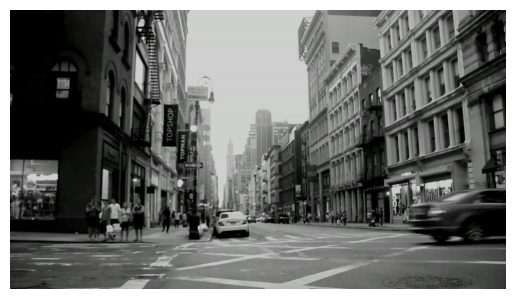

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing the street in a city setting.'}


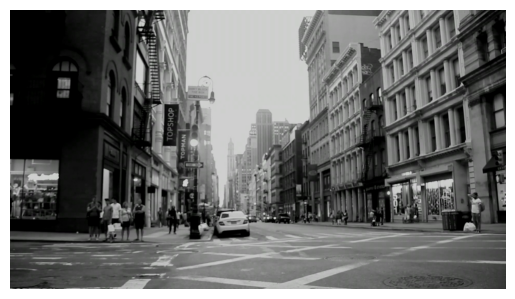

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing the street in a city setting.'}


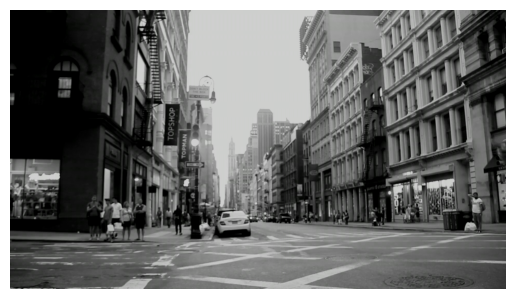

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing the street'}


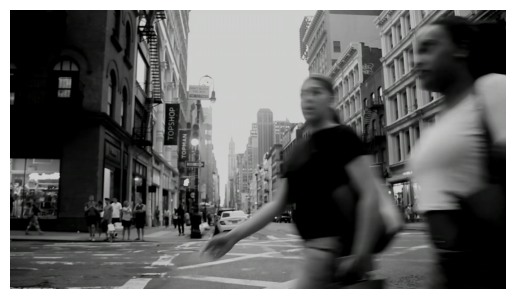

In [8]:
question = 'a car crossing the street'
prompt = format_prompt_qa_event_existence(question)

for f in frames[:5]:
    print(
        process_frame(f, prompt)
    )
    show_frame(f)

## QA on a entire video

In [ ]:
from dataclasses import dataclass
from typing import Callable, List, Union


@dataclass
class EventExistInference:
    ts: str
    exist: bool
    description: str


@dataclass
class FrameDescriptionInference:
    ts: str
    description: str


def qa_video(qa_video_fn: Callable):
    def wrapper(path: str, *args, **kwargs):
        outputs = []

        video_path = os.path.abspath(path)
        frames, timestamps = extract_frames(video_path)

        question = kwargs.get("question")
        prompt = (
            format_prompt_qa_event_existence(question)
            if question
            else format_prompt_qa_frame_description()
        )

        for f, ts in zip(frames, timestamps):
            r = process_frame(f, prompt)
            outputs.append(qa_video_fn(ts, r))

        return outputs

    return wrapper


@qa_video
def qa_video_event_existence(ts: str, r: dict) -> EventExistInference:
    return EventExistInference(
        ts=ts,
        exist=r["exists"],
        description=r["description"],
    )


@qa_video
def qa_video_frame_description(ts: str, r: dict) -> FrameDescriptionInference:
    return FrameDescriptionInference(
        ts=ts,
        description=r["description"],
    )

In [12]:
# WHY CANT YOU RECOGNIZE TRIVIAL EVENTS?
qa_video_event_existence("../public/video_teste02.mp4", question="a person crossing the street")

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for

[EventExistInference(ts=0.0, exist=False, description='A person crossing the street in a city setting with buildings, traffic lights, and pedestrians.'),
 EventExistInference(ts=1.0, exist=False, description='A person crossing the street in a red building with a blue sign and a white building with a red sign.'),
 EventExistInference(ts=2.0, exist=False, description='A person crossing the street'),
 EventExistInference(ts=3.0, exist=False, description='A person crossing the street in a city setting with buildings and traffic lights'),
 EventExistInference(ts=4.0, exist=False, description='A person crossing the street in a city setting with buildings, traffic lights, and a blue sky.'),
 EventExistInference(ts=5.0, exist=False, description='A person crossing the street in a city setting with buildings and traffic lights'),
 EventExistInference(ts=6.0, exist=False, description='A person crossing the street in a city setting with buildings and traffic lights'),
 EventExistInference(ts=7.0, 

## Describe what is happening on a video

In [14]:
# TODO a better approach would be saving each frame description and with RAG get the frame timestamp with the closest description accordingly to user prompt
# Instead of only description, a better approach would be ask of more entities on the frame object
# {
#     "ts": 1.0,
#     "objects": "car, truck, pedestrian, traffic light, building",
#     "actions": "pedestrian crossing, vehicles parked",
#     "colors": "red building, white truck, blue sky",
#     "full_description": "... original LLaVA output ..."
# }
qa_video_frame_description("../public/video_teste02.mp4")

# use sentence-transformers/all-MiniLM-L6-v2 to get the embeddings and cossine similarity

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for

[FrameDescriptionInference(ts=0.0, description=None),
 FrameDescriptionInference(ts=1.0, description=None),
 FrameDescriptionInference(ts=2.0, description=None),
 FrameDescriptionInference(ts=3.0, description=None),
 FrameDescriptionInference(ts=4.0, description='A street scene with cars, buildings, and traffic lights. The street is narrow and has a mix of residential and commercial buildings. There are multiple traffic lights, some of which are red. The buildings have different colors, including pink, blue, and red. The street is surrounded by trees and has a clear blue sky. There are no pedestrians or cyclists visible in the image. The traffic lights are positioned at various points along the street, with some closer to the buildings and others further away. The buildings have different architectural styles, with some featuring brickwork and others featuring more modern materials. The street appears to be a residential area with a mix of houses and commercial buildings. The overall a